<a href="https://colab.research.google.com/github/thiagotandrade/ds_project/blob/master/DS_Project1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TODO: 
- Usar classificador e regressor para tratar dados faltantes;
- Separar os bathroomcnt em duas colunas: uma indicando a quantidade de banheiros completos e outra indicando a quantidade de banheiros fracionados (banheiros completos: converter o valor pra inteiro; banheiros fracionados: 1 se o bathroomcnt tiver decimal e 0 cc).
- Escolher as melhores features (usar XGBoost, ver correlação entre variáveis e alvo).

# Projeto 1 da Disciplina Data Science 2019.1, CIn - UFPE
# Competição do Kaggle: [Zillow Prize](https://www.kaggle.com/c/zillow-prize-1)

## Configurando ambiente

### Imports

In [0]:
!pip install missingpy
!pip install pyspark

import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns


from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
from pyspark.ml.feature import QuantileDiscretizer
from sklearn.preprocessing import LabelEncoder

sc = SparkContext('local')
spark = SparkSession(sc)
pd.options.mode.chained_assignment = None
%matplotlib inline

    100% |████████████████████████████████| 51kB 2.0MB/s 
    100% |████████████████████████████████| 215.7MB 86kB/s 
    100% |████████████████████████████████| 204kB 30.7MB/s 
  Stored in directory: /root/.cache/pip/wheels/47/9b/57/7984bf19763749a13eece44c3174adb6ae4bc95b920375ff50
Successfully built pyspark


In [0]:
# Variável para indicar se a imputação já foi feita anteriormente
imputed = True

### Lendo versão 2016 dos arquivos CSV

In [0]:
props = pd.read_csv('https://raw.githubusercontent.com/thiagotandrade/ds_project/master/Database/merged_2016v2.csv',
                    header=0, sep=',', quotechar='"')
props_bkp = props.copy()

## 2. Pré-processamento dos dados

In [0]:
props.tail().transpose()

,90270,90271,90272,90273,90274
parcelid,11876798,12808516,12010248,14310905,14636609
airconditioningtypeid,1,NaN,1,NaN,NaN
architecturalstyletypeid,NaN,NaN,NaN,NaN,NaN
basementsqft,NaN,NaN,NaN,NaN,NaN
bathroomcnt,3,2,2,2.5,2.5
bedroomcnt,4,3,2,3,3
buildingclasstypeid,NaN,NaN,NaN,NaN,NaN
buildingqualitytypeid,4,7,4,NaN,NaN
calculatedbathnbr,3,2,2,2.5,2.5
decktypeid,NaN,NaN,NaN,NaN,NaN


In [0]:
props.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
parcelid,90275.0,1.298466e+07,2.504510e+06,1.071174e+07,1.155950e+07,1.254734e+07,1.422755e+07,1.629608e+08
airconditioningtypeid,28781.0,1.816372e+00,2.974168e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.300000e+01
architecturalstyletypeid,261.0,7.229885e+00,2.716196e+00,2.000000e+00,7.000000e+00,7.000000e+00,7.000000e+00,2.100000e+01
basementsqft,43.0,7.135814e+02,4.374342e+02,1.000000e+02,4.075000e+02,6.160000e+02,8.720000e+02,1.555000e+03
bathroomcnt,90275.0,2.279474e+00,1.004271e+00,0.000000e+00,2.000000e+00,2.000000e+00,3.000000e+00,2.000000e+01
bedroomcnt,90275.0,3.031869e+00,1.156436e+00,0.000000e+00,2.000000e+00,3.000000e+00,4.000000e+00,1.600000e+01
buildingclasstypeid,16.0,4.000000e+00,0.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00
buildingqualitytypeid,57364.0,5.565407e+00,1.900602e+00,1.000000e+00,4.000000e+00,7.000000e+00,7.000000e+00,1.200000e+01
calculatedbathnbr,89093.0,2.309216e+00,9.761725e-01,1.000000e+00,2.000000e+00,2.000000e+00,3.000000e+00,2.000000e+01
decktypeid,658.0,6.600000e+01,0.000000e+00,6.600000e+01,6.600000e+01,6.600000e+01,6.600000e+01,6.600000e+01


In [0]:
# Não faz Sentido

# Inserir valor true na coluna 'fireplaceflag' se houve algum valor presente em fireplacecnt diferente de zero ou NaN
#props.loc[props['fireplacecnt'] != 0 | pd.notnull(props['fireplacecnt']),'fireplaceflag'] = "True"

### 2.1 Definição de tipos

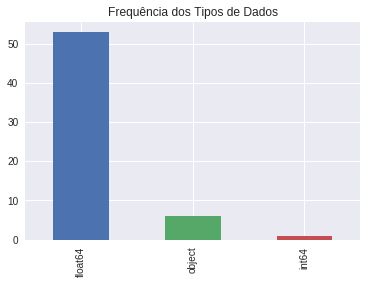

In [0]:
props.dtypes.value_counts().sort_values(ascending=False).plot.bar(title='Frequência dos Tipos de Dados')

In [0]:
# Mudando colunas de tipo 'object' para tipo 'category'
object_type = props.select_dtypes(include=['object']).columns.values
props[object_type] = props[object_type].astype('category')

#Mudar tipo da coluna transaction date para 'datetime64' e separando a data em colunas
props['transactiondate'] = pd.to_datetime(props['transactiondate'])
props['transaction_year'] = props['transactiondate'].dt.year
props['transaction_month'] = props['transactiondate'].dt.month
props['transaction_day'] = props['transactiondate'].dt.day
props.drop(['transactiondate'], axis=1, inplace=True)

### 2.2 Tratamento de dados ausentes

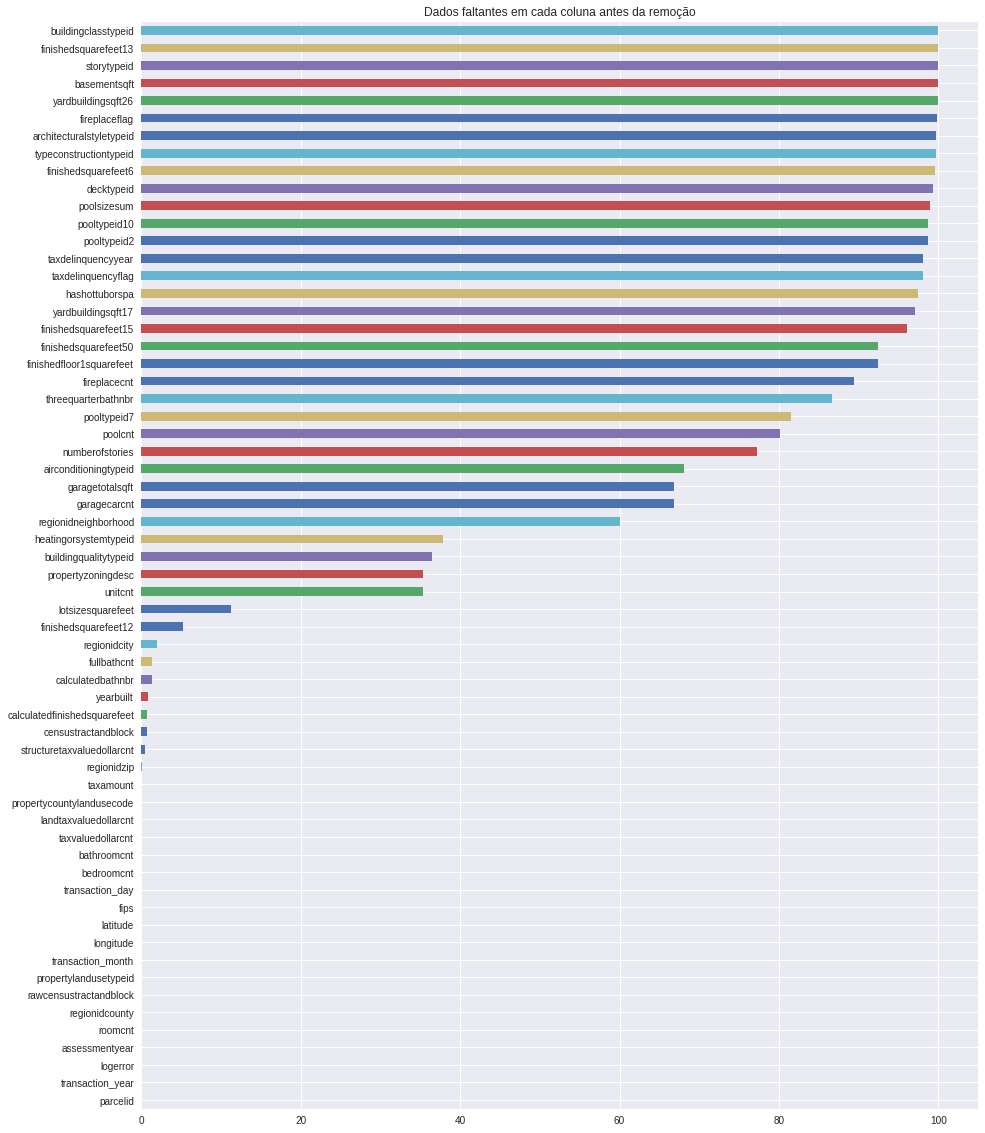

In [0]:
((props.isnull().sum()/len(props))*100).sort_values().plot.barh(figsize=(15,20), title='Dados faltantes em cada coluna antes da remoção')

#missingValueColumns = props.columns[props.isnull().any()].tolist()
#msno.bar(props[missingValueColumns])

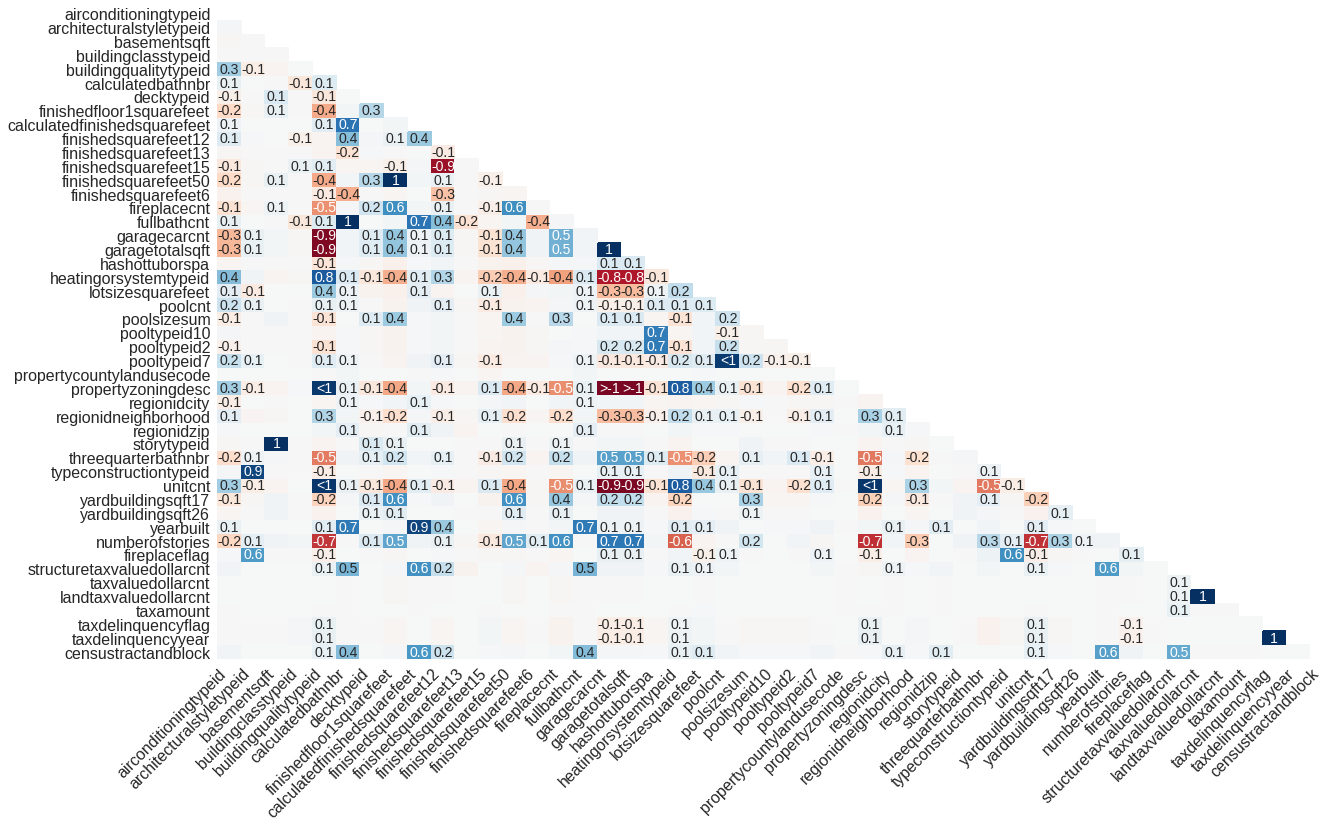

In [0]:
msno.heatmap(props)

#### 2.2.1 Remoção de dados

In [0]:
props.shape

(90275, 62)

Remoção de Instâncias

In [0]:
#df.dropna(thresh=2)   #Drop row if it does not have at least two values that are **not** NaN

#A coluna 'fireplaceflag' não adiciona nenhuma informação útil pois df já possui 'fireplacecnt', então removemos:
props.drop(['fireplaceflag'], axis=1, inplace=True)

# Remover colunas com mais de 50% de dados ausentes
props.dropna(thresh=(0.5*len(props.columns.values)) , axis=0, inplace=True)

#*********************AJUSTAR PARA COLUNAS QUE FAZEM SENTIDO*******************#
# Remover instâncias que não tem 'bathroomcnt'
props = props[pd.notnull(props['bathroomcnt'])]

# Remover instâncias que não tem 'bedroomcnt'
props = props[pd.notnull(props['bedroomcnt'])]


Remoção de colunas

In [0]:
# Remover colunas com mais de 70% de dados ausentes
props.dropna(thresh=0.70*len(props), axis=1, inplace=True)

In [0]:
props.shape

(86480, 29)

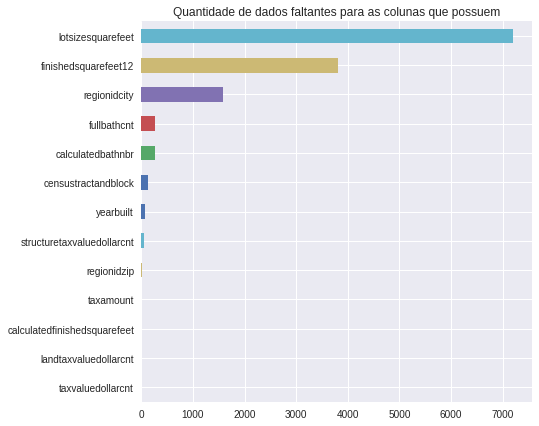

In [0]:
nan_series_cols = props.isnull().sum()
nan_series_cols[nan_series_cols != 0].sort_values().plot.barh(figsize=(7,7), title='Quantidade de dados faltantes para as colunas que possuem')
#props.isnull().sum().sort_values().plot.barh(figsize=(15,20))

#### 2.2.2 Imputação de dados

[Obtendo colunas que contém valores NaN](https://dzone.com/articles/pandas-find-rows-where-columnfield-is-null)

In [0]:
# Get columns that have any NaN value
nan_columns = props.columns[props.isnull().any()]

Baseando-se correlação para medir algum impacto na imputação:

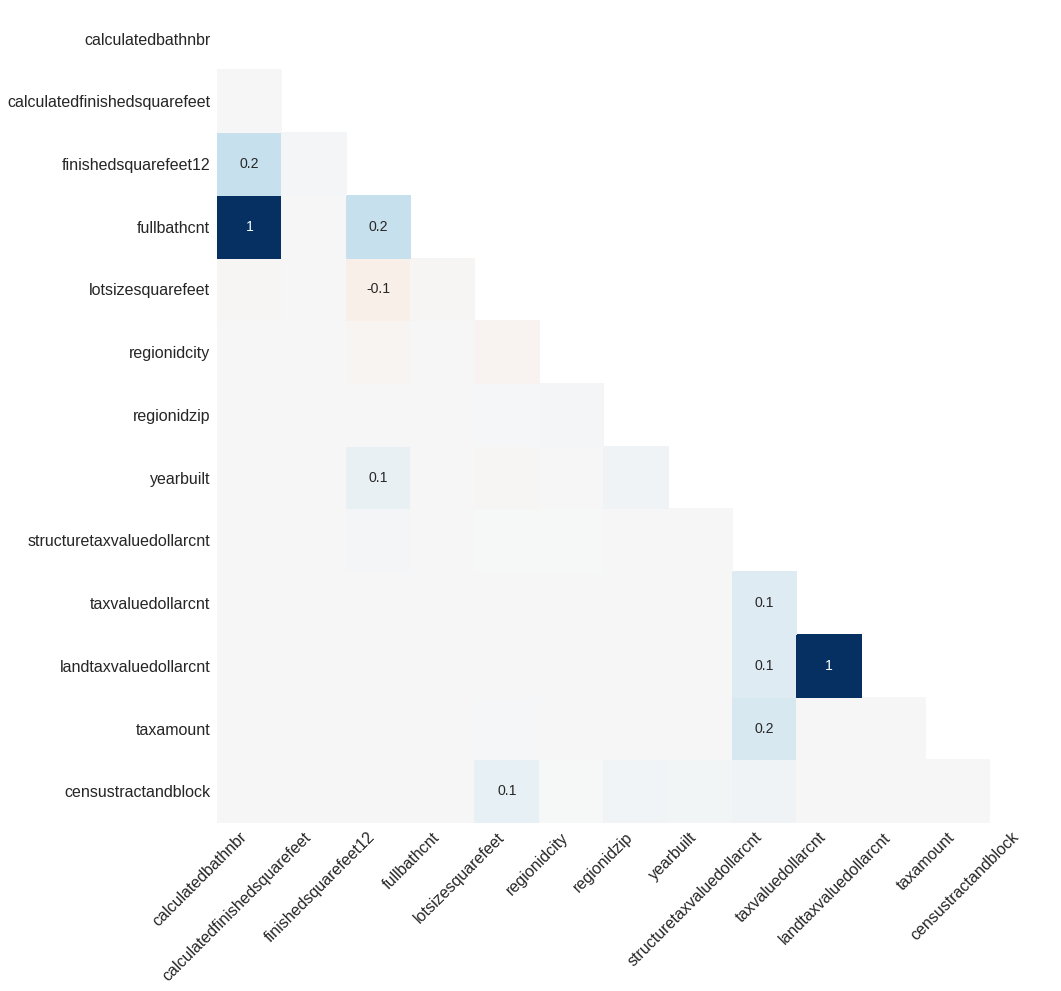

In [0]:
msno.heatmap(props[nan_columns], figsize=(15,15))
#All Columns Correlation
#f,ax = plt.subplots(figsize=(15, 15))
#sns.heatmap(props.corr(), annot=True, linewidths=.5, fmt='.1f',ax=ax)
#plt.show()

##### Dados Categóricos [aqui](https://www.datacamp.com/community/tutorials/categorical-data) e [aqui](https://scikit-learn.org/stable/modules/impute.html)

In [0]:
cat_df_nan = props[nan_columns].select_dtypes(include=['category']).copy()

In [0]:
cat_df_nan.head()

""
0
1
2
3
4


In [0]:
print('Total NaN values in categorical data: ' + str(cat_df_nan.isnull().values.sum()))
print(cat_df_nan.isnull().sum())

Total NaN values in categorical data: 0.0
Series([], dtype: float64)


Tentar usar o fancyimpute do sklearn para fazer a imputação com outros algoritmos fora o kNN

Usando kNN para imputação de dados categóricos

In [0]:
category_type = props.select_dtypes(include=['category']).columns.values
#props_codes[category_type] = props_codes[category_type].cat.codes

In [0]:
category_type = props.select_dtypes(include=['category']).columns.values
for c in category_type:
  props[c] = props[c].cat.codes

In [0]:
def saveToCsv(df, columns, index):
  
  df_out = pd.DataFrame(data=df)
  props_df.columns = props.columns.values.tolist()
  df_out.set_index(index, inplace=True, drop=True)
  df_out.to_csv('props_imputed.csv')
  
  from google.colab import files
  files.download('props_imputed.csv')

In [0]:
'''

  Se já executou anteriormente, settar imputed para True.
  Se não, settar imputed para False para fazer a imputação.
  
'''

if(imputed):
  props_imputed = pd.read_csv('https://raw.githubusercontent.com/thiagotandrade/ds_project/master/Database/props_imputed.csv',
                             header=0, sep=',', quotechar='"')
else:
  from missingpy import MissForest
  imputer = MissForest()
  props_imputed = imputer.fit_transform(props)
  saveToCsv(props_imputed, props.columns.values.tolist(), 'parcelid')

In [0]:
#lb_make = LabelEncoder()
#props['propertycountylandusecode'] = lb_make.fit_transform(props['propertycountylandusecode'])

#props_knn = KNN(k=3).fit_transform(props)

##### Dados Numéricos

In [0]:
num_df_nan = props[nan_columns].select_dtypes(exclude=['category']).copy()
#num_nan = props[list(set(props.columns.values).difference(num_df_nan.columns.values))]

In [0]:
num_df_nan.shape

(86480, 13)

### 2.3 Normalização e discretização

#### 2.3.2 Normalização

#### 2.3.1 Discretização

In [0]:
# Pyspark QuantileDiscretizer: Discretizar a coluna 'yearbuilt'
props_spark = spark.createDataFrame(props,props.columns.values.tolist())
props_spark_result = QuantileDiscretizer(numBuckets=10, inputCol="yearbuilt",outputCol="year_built_intervals").fit(props_spark).transform(props_spark)
props_spark_result.show()

+--------+-----------+----------+-----------------+----------------------------+--------------------+------+-----------+-----------+-------------+-----------------+-------------------------+---------------------+----------------------+------------+--------------+-----------+-------+---------+--------------------------+-----------------+--------------+---------------------+---------+-------------------+--------------------+----------------+-----------------+---------------+--------------------+
|parcelid|bathroomcnt|bedroomcnt|calculatedbathnbr|calculatedfinishedsquarefeet|finishedsquarefeet12|  fips|fullbathcnt|   latitude|    longitude|lotsizesquarefeet|propertycountylandusecode|propertylandusetypeid|rawcensustractandblock|regionidcity|regionidcounty|regionidzip|roomcnt|yearbuilt|structuretaxvaluedollarcnt|taxvaluedollarcnt|assessmentyear|landtaxvaluedollarcnt|taxamount|censustractandblock|            logerror|transaction_year|transaction_month|transaction_day|year_built_intervals|
+-

### 2.4 Limpeza de dados

#### 2.4.1 Univariado

#### 2.4.2 Bivariado

#### 2.4.3 Multivariado

## Criação de Novas Features

## Visualização de Dados

#### Distribuição da localização das propriedades

In [0]:
props['latitude'] /= 1e6
props['longitude'] /= 1e6

In [0]:
plt.figure(figsize=(12,12))
sns.jointplot(x=props.latitude.values, y=props.longitude.values, size=10)
plt.ylabel('Longitude', fontsize=12)
plt.xlabel('Latitude', fontsize=12)
plt.show()

In [0]:
#Save for later

#Get all null columns as dataframe 
#print(props[props.isnull().any(axis=1)][nan_columns].head())

#props_train = pd.merge(props, train, on='parcelid', how='left')

#msno.dendrogram(props)

# Changing type of columns with Ids to unsigned short int
#id_columns = props.filter(regex='id').columns.values
#props[id_columns].astype('uint16')

# Para a coluna propertycountylandusecode não precisamos de imputação, logo apenas transformamos as categorias para código
# cat_df_props['propertycountylandusecode'] = cat_df_props['propertycountylandusecode'].cat.codes.astype('int16')
#cat_df_props['propertyzoningdesc'] = cat_df_props['propertyzoningdesc'].cat.codes.astype('int16')

###############################################################################################################################

#Para excluir

# Não podemos usar o one hot encoder pois precisariamos criar 240 novas colunas para um dataframe com 3 mi instâncias
#cat_df_props['propertycountylandusecode'].cat.categories

#prop_county_land_use_code = cat_df_props['propertycountylandusecode'].cat.codes
#prop_county_land_use_code

#lb_make = LabelEncoder()
#cat_df_props['propertycountylandusecode'] = lb_make.fit_transform(cat_df_props['propertycountylandusecode'])